In [64]:
import requests 
from PIL import Image
from matplotlib import pyplot as plt


import cv2 
import pytesseract
import numpy as np
import pandas as pd
import glob
import os

# internal libraries
import sys; sys.path.append('../')
import vision

DATA_DIR = '../test-data/'

In [10]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model_name='microsoft/trocr-small-printed'
processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)
# load image from the IAM dataset 
url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg" 
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = Image.open(os.path.join(DATA_DIR,'5.png')).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values 
generated_ids = model.generate(pixel_values)

processor.batch_decode(generated_ids, skip_special_tokens=False)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\David\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\generation_utils.py:1227: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum lengt

['</s> ^2ASF_^9 POWER TOOL</s>']

In [15]:
pixel_values.shape, image.height,image.width

(torch.Size([1, 3, 384, 384]), 16, 110)

In [21]:
imarr = cv2.imread(DATA_DIR + '3.png')
imarr = cv2.cvtColor(imarr,cv2.COLOR_BGR2RGB)
Image.fromarray(imarr).convert("RGB")

# cv2

In [2]:

def preprocess(og_img):
    img = cv2.cvtColor(og_img,cv2.COLOR_RGB2GRAY)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # img = cv2.bitwise_not(img)
    return img


def get_contour_bboxs(gray: np.ndarray, verbose=False):
    contours = cv2.findContours(gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[0]
    bboxes = []
    if verbose: 
        output = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB).copy()
        output = cv2.bitwise_not(output)
    
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        if peri > 500:
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                bboxes.append(cv2.boundingRect(approx))
                if verbose:
                    x,y,w,h = cv2.boundingRect(approx)
                    cv2.rectangle(output,(x,y),(x+w,y+h),(36,255,12),2)

    if verbose: 
        plt.imshow(output)
    return bboxes


In [59]:
imgs = [
    os.path.join(DATA_DIR,'2hu1bUHL1mc_frame12-1.png'),
    os.path.join(DATA_DIR,'2hu1bUHL1mc_frame9-0.png') 
]
imgs = map(cv2.imread, imgs)
imgs = [cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in imgs]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


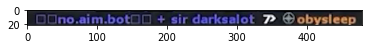

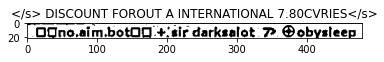

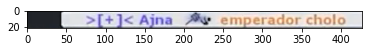

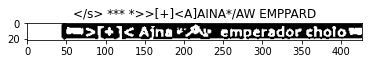

In [72]:
ocr = vision.TrOCR()
for rgb_img in imgs:
    plt.figure()
    plt.imshow(rgb_img)
    img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img,(3,3),0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,17,-1)
    # img = cv2.Canny(img,100,200)
    text = ocr.get_text(img)

    plt.figure()
    plt.title(text)
    plt.imshow(img, cmap='binary')


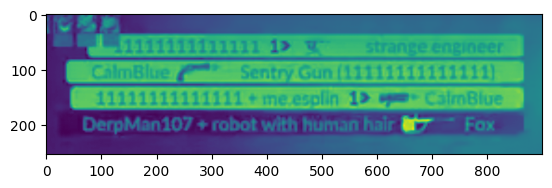

In [4]:
plt.imshow(cv2.cvtColor(og_img,cv2.COLOR_RGB2GRAY))

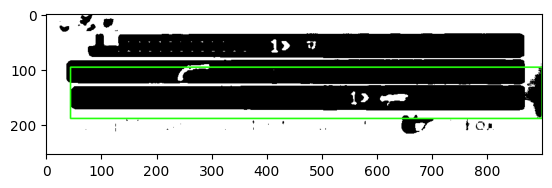

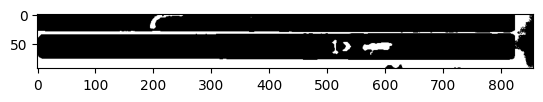

In [5]:
img = preprocess(og_img)

plt.figure()
for x,y,w,h in get_contour_bboxs(img,True):
    crop = img[y:y+h,x:x+w]

    df = pytesseract.image_to_data(crop, output_type="data.frame")
    text = ' '.join(df.text[df.conf > 30])
    
    plt.figure()
    plt.imshow(crop,cmap='binary')
    plt.title(text)
    cv2.imwrite(text+'.png',crop)


In [9]:
crops = [crop_with_bbox(img,b) for b in get_contour_bboxs(img)]

df = pytesseract.image_to_data(crops[2], output_type="data.frame")
print(' '.join(df.text[df.conf > 30]))
df

    Fred Bamburger ™ MingeNinja    


,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,293,24,-1.000000,NaN
1,2,1,1,0,0,0,0,0,293,1,-1.000000,NaN
2,3,1,1,1,0,0,0,0,293,1,-1.000000,NaN
3,4,1,1,1,1,0,0,0,293,1,-1.000000,NaN
4,5,1,1,1,1,1,0,0,293,1,95.000000,
5,2,1,2,0,0,0,0,0,1,24,-1.000000,NaN
6,3,1,2,1,0,0,0,0,1,24,-1.000000,NaN
7,4,1,2,1,1,0,0,0,1,24,-1.000000,NaN
8,5,1,2,1,1,1,0,0,1,24,95.000000,
9,2,1,3,0,0,0,22,4,245,16,-1.000000,NaN


In [123]:
# image = Image.fromarray(img).convert("RGB")
test_image = cv2.imread('t.png')
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
color_img = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)

pixel_values = processor(color_img, return_tensors="pt").pixel_values 
generated_ids = model.generate(pixel_values)
processor.batch_decode(generated_ids, skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\David\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\generation_utils.py:1227: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['FRESH EAMINIER : ~ 2AF~ *9 POWER TOBACCO']

In [116]:
pytesseract.image_to_string(img, config='--oem 1 --psm 3')

'Fred Bamburger jai *ZAsF_*9 Power Tool\n\nFred Bamburger @#™s" ™ MingeNinja\n\ni .\n'

### Using the thresholdized text segment actually works

In [128]:
img = cv2.imread('5.png')
pixel_values = processor(img, return_tensors="pt").pixel_values 
generated_ids = model.generate(pixel_values)
processor.batch_decode(generated_ids, skip_special_tokens=False)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['</s> ^2ASF_^9 POWER TOOL</s>']

## We could use derivatives to find the HUD
It may benefit from using many images

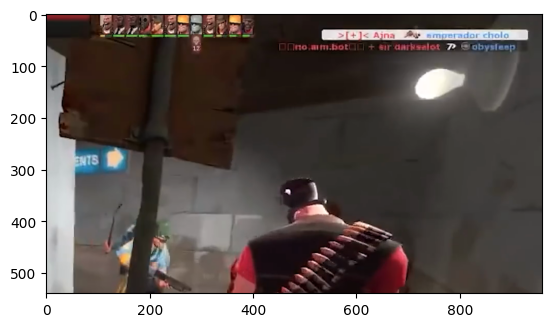

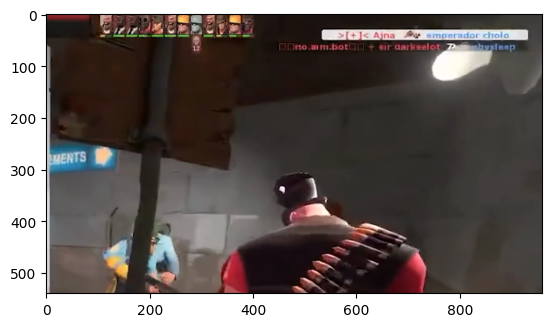

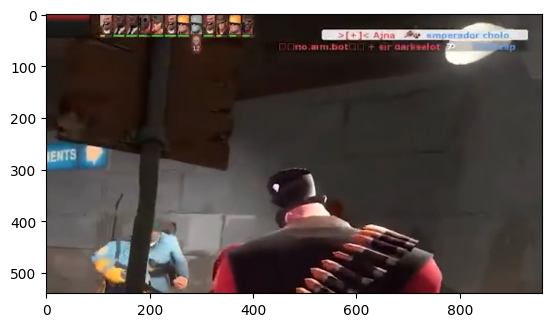

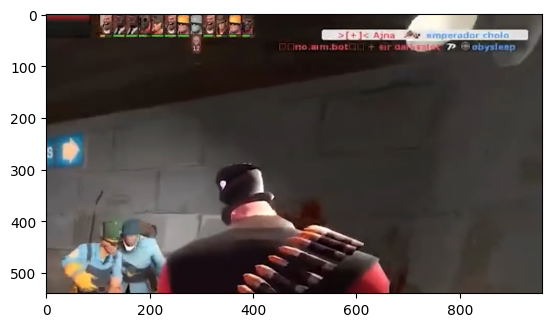

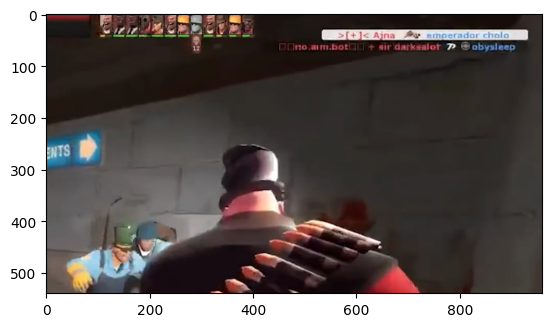

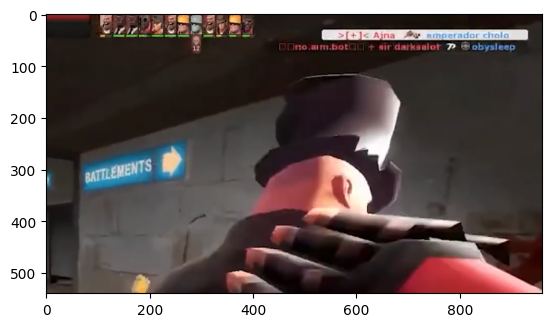

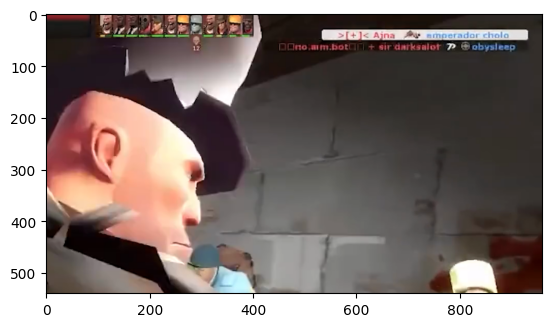

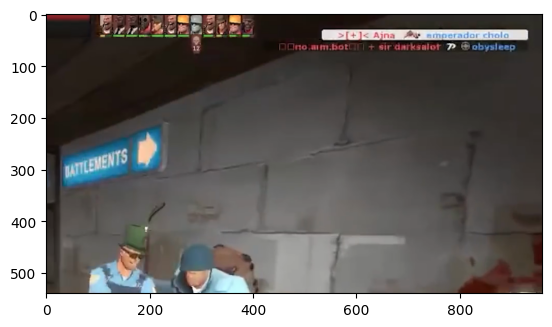

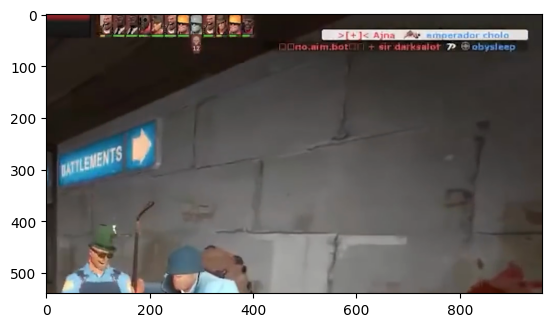

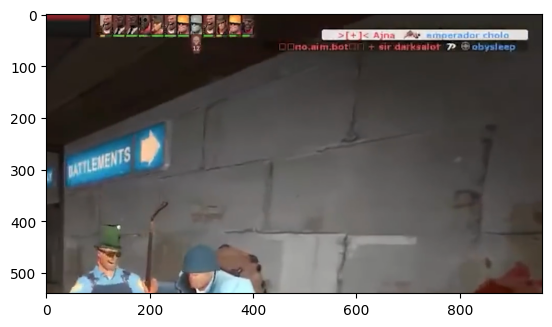

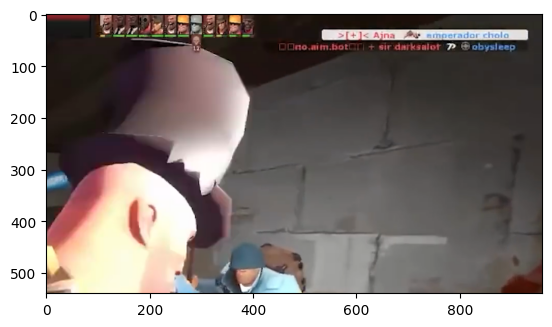

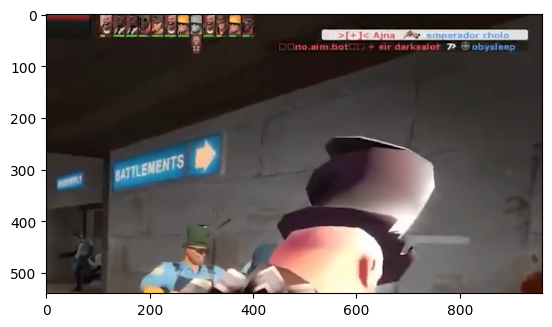

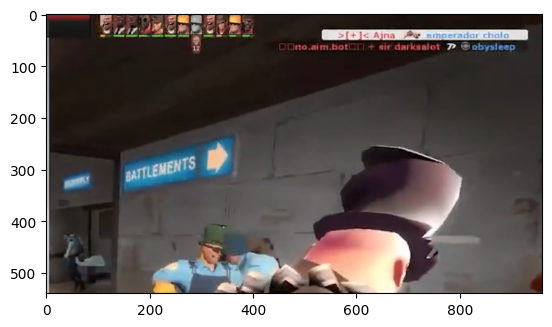

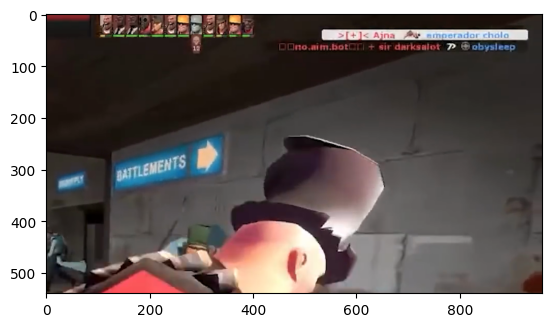

In [56]:
img_range = range(66,80)
get_img = lambda path: cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
imgs = [get_img(f'{DATA_DIR}out/{i}.png') for i in img_range]
imgs = np.stack(imgs) # time, height, width, channels
imgs.shape

for i in imgs:
    plt.figure()
    plt.imshow(i)

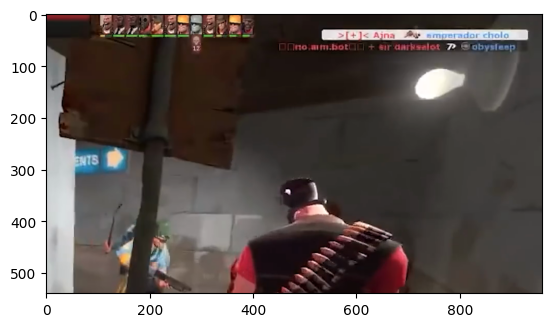

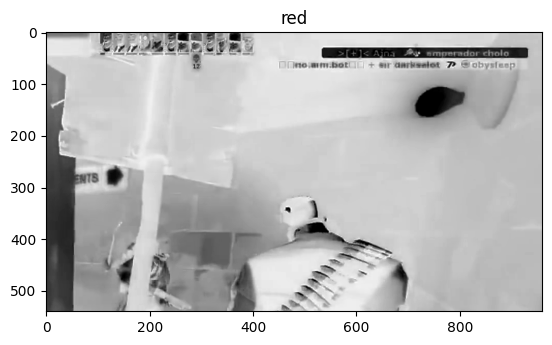

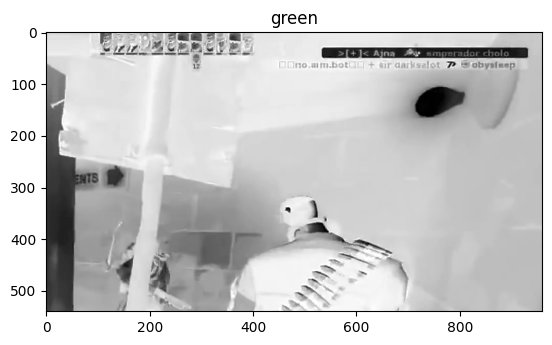

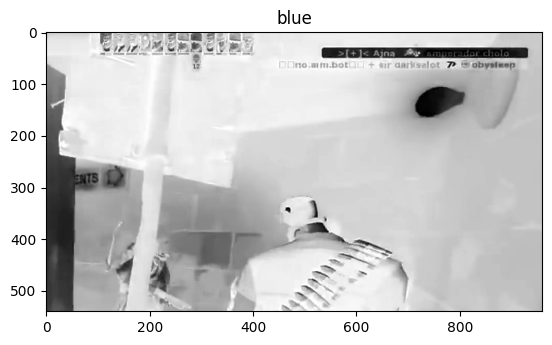

In [61]:
plt.figure()
plt.imshow(imgs[0,:,:])
plt.figure()
plt.title('red')
plt.imshow(imgs[0,:,:,0],cmap='binary')
plt.figure()
plt.title('green')
plt.imshow(imgs[0,:,:,1],cmap='binary')
plt.figure()
plt.title('blue')
plt.imshow(imgs[0,:,:,2],cmap='binary')

In [5]:
data_path = lambda filename: os.path.join(DATA_DIR, filename)
im1 = cv2.cvtColor(cv2.imread(data_path('268.png')), cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(cv2.imread(data_path('272.png')), cv2.COLOR_BGR2GRAY)
imgs = np.stack([im1,im2])
imgs.shape
plt.figure()
plt.imshow(im1,cmap='binary')
plt.figure()
plt.imshow(im2,cmap='binary')

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


(13, 540, 960, 3)


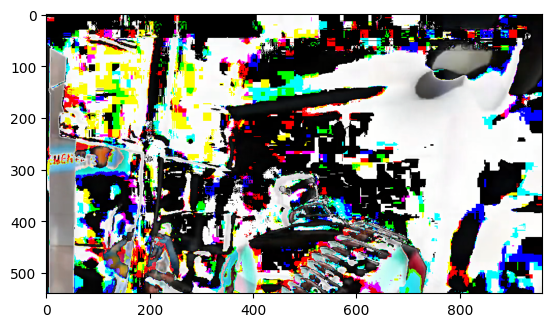

In [62]:
diff = np.abs(np.diff(imgs,1,0))

print(diff.shape)
plt.imshow(diff[0],cmap='afmhot')